# Estudiantes:
- Grezzi, Nicolas. N° 189702
- Chicatun, Mariano. N° 301379

# Value Iteration

Vamos a ver como la programación dinamica se puede utilizar para derivar políticas óptimas para algunos ambientes. En este caso particular vamos a utilizar dos ambientes definidos en el libro de Sutton y Barto. 

Es recomendable leer el capítulo 4 del libro para entender a fondo todos los conceptos.

## A entregar:

- Notebook con el algoritmo de value iteration implementado (hecho en clase)
- Comentarios sobre funciones implementadas en clase, que hacen y que es cada parametro.
- Reporte con funciones de valor para diferentes tamaños de ambiente.
- Reporte con graficas sobre el numero de iteraciones del algoritmo para diferentes tamaños de ambiente.


## Definicion del ambiente

En este caso vamos a usar como ambiente algo muy sencillo, Gridworld (del libro de Sutton y Barto). Basicamente se trata de una grilla rectangular de posibles posiciones donde los estados terminales se encuentran en la esquina superior izquierda ([0,0] en coordenadas) y en la esquina inferior derecha ([largo - 1, ancho - 1] en coordenadas). 

El objetivo es obtener la función de valor óptima para el entorno en el que estamos.

Comenzamos definiendo el ambiente como una clase Python abajo, esto nos va a permitir crear varios ambientes de prueba para probar nuestro algoritmo y encontrar la función optima para todos.

In [15]:
# Necessary imports
import io
import sys
import numpy as np
#from gym.envs.toy_text import discrete
from DiscreteEnv import DiscreteEnv

# Possible Actions
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

In [16]:
class GridworldEnv(DiscreteEnv):
    """
    ****
    Forked from: https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/gridworld.py
    ****
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.

    For example, a 4x4 grid looks as follows:

    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T

    x is your position and T are the two terminal states.

    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    def __init__(self, shape=[4,4]):
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('Shape argument must be a list/tuple of length 2')

        self.shape = shape

        number_states = np.prod(shape)
        number_actions = 4
        
        self.number_actions = number_actions
        self.number_states = number_states

        MAX_Y = shape[0]
        MAX_X = shape[1]

        transition_probabilities = {}
        grid = np.arange(number_states).reshape(shape)
        it = np.nditer(grid, flags=['multi_index'])

        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            transition_probabilities[s] = {a : [] for a in range(number_actions)}

            is_done = lambda s: s == 0 or s == (number_states - 1)
            reward = 0.0 if is_done(s) else -1.0

            # We're stuck in a terminal state
            if is_done(s):
                transition_probabilities[s][UP] = [(1.0, s, reward, True)]
                transition_probabilities[s][RIGHT] = [(1.0, s, reward, True)]
                transition_probabilities[s][DOWN] = [(1.0, s, reward, True)]
                transition_probabilities[s][LEFT] = [(1.0, s, reward, True)]
            # Not a terminal state
            else:
                ns_up = s if y == 0 else s - MAX_X
                ns_right = s if x == (MAX_X - 1) else s + 1
                ns_down = s if y == (MAX_Y - 1) else s + MAX_X
                ns_left = s if x == 0 else s - 1
                transition_probabilities[s][UP] = [(1.0, ns_up, reward, is_done(ns_up))]
                transition_probabilities[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
                transition_probabilities[s][DOWN] = [(1.0, ns_down, reward, is_done(ns_down))]
                transition_probabilities[s][LEFT] = [(1.0, ns_left, reward, is_done(ns_left))]

            it.iternext()

        # Initial state distribution is uniform
        isd = np.ones(number_states) / number_states

        # We expose the model of the environment for educational purposes
        # This should not be used in any model-free learning algorithm
        self.transition_probabilities = transition_probabilities

        super(GridworldEnv, self).__init__(number_states, number_actions, transition_probabilities, isd)

## Inicializando una nueva instancia del ambiente

En la celda de abajo vamos a crear una nueva instancia del ambiente definido arriba. En este caso, y por ser un ejemplo, conocemos la funcion de transición del ambiente (llamada `transition_probabilities`). Esta función nos dice, para cada estado, el resultado de tomar cada accion posible.

*** 

Esta funcion esta representada por tuplas de la forma: `(Probabilidad, estado_siguiente, recompensa, estado_final)`. 

- Al ser un ambiente deterministico las **probabilidades** son siempre 1 (al tomar una accion tenemos 100% de chances de caer en el siguiente estado, otros casos una acción podría tener una distribuccion de probabilidades sobre todos los estados posibles).

- Los **estados_siguientes** apuntan a dónde mirar en la funcion de transición.

- Las **recompensas** como se mencionó arriba son siempre -1 por cada movimiento, excepto cuando estamos en un estado final.

- El **estad_final** es un flag booleano (Verdadero o Falso) que nos dice si el estado al que nos movemos es final o no.

***

Por ejemplo: si estamos en el estado 0, tomar cualquier accion tiene recompensa 0, con probabilidad 100% (es un ambiente determinístico) y 

In [3]:
grid = GridworldEnv()   # Create a new gridworld object
grid.transition_probabilities

# Recordar: 
# UP = 0
# RIGHT = 1
# DOWN = 2
# LEFT = 3

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

## Recordando Value Iteration del libro de Sutton y Barto:

![Image](https://i.imgur.com/PBtFBCG.png)


Este es el algoritmo que vamos a implementar en las celdas siguientes.

La función de valor del ambiente anterior debería ser:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

In [4]:
def compute_action_values(env, state, V, gamma=1.0):
    """
    Helper function to calculate the value for all actions in a given state.
    
    Args:
        env: openAI.gym environment
        state: The state to consider (int)
        V: The value to use as an estimator, Vector of length env.number_states
        gamma: Gamma discount factor.

    
    Returns:
        A vector of length env.number_actions containing the expected value of each action.
    """   

    actionvalues = np.zeros(env.number_actions)

    for action in range(env.number_actions):
        for prob, nextstate,reward,_ in env.transition_probabilities[state][action]:
            actionvalues[action] += prob*(reward + gamma*V[nextstate])
    return actionvalues


In [5]:
def value_iteration(env, theta=0.0001, gamma=1.0):
    """
    Value Iteration Algorithm.

    Args:
    env: OpenAI env. env.transition_probabilities represents the transition probabilities of the environment.
        env.transition_probabilities[s][a] is a list of transition tuples (prob, next_state, reward, done).
        env.number_states is a number of states in the environment. 
        env.number_actions is a number of actions in the environment.
    theta: We stop evaluation once our value function change is less than theta for all states.
    gamma: Gamma discount factor.

    Returns:
    A tuple (policy, V, count) of the optimal policy and the optimal value function.
    """
    V = np.zeros(env.number_states)
    delta = theta + 1 # -> Esto se puede elegir arbitrariamente casi. Es para que entre en el while delta > theta
    counter = 0 # Cuantas iteraciones hizo el algoritmo para converger. Lo que decía Bellman que pasa si la cantidad de acciones se dispara. 

    while delta > theta: 
        delta = 0 
        for s in range(env.number_states):
            counter += 1 
            valueaction = compute_action_values(env, s, V, gamma)
            bestactionvalue = np.max(valueaction)
            delta = max(delta, np.abs(bestactionvalue- V[s]))
            V[s] = bestactionvalue
    policy = np.zeros([env.number_states,env.number_actions])
    for s in range(env.number_states):
        valueactions = compute_action_values(env,s,V,gamma)
        bestaction = np.argmax(valueactions)
        policy[s,bestaction] = 1.0


    return policy, V, counter


In [6]:
env = GridworldEnv()
policy, v, count = value_iteration(env)   # get the count as well

print(f"For env size 4 the number of iterations was {count}")

For env size 4 the number of iterations was 64


In [15]:
env = GridworldEnv([50,50])
policy, v, count = value_iteration(env)   # get the count as well

print(f"For env size 50 the number of iterations was {count}")

For env size 4 the number of iterations was 125000


In [16]:
print("Policy Probability Distribution:")
print(policy)
print("")

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]



In [17]:
print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 ... 3 3 2]
 [0 0 0 ... 0 0 2]
 [0 0 0 ... 0 1 2]
 ...
 [0 0 0 ... 1 1 2]
 [0 0 1 ... 1 1 2]
 [0 1 1 ... 1 1 0]]



In [9]:
print("Value Function:")
print(v)
print("")

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]



Algunas funciones de valor:
Ambiente 5x5: [ 0. -1. -2. -3. -4. -5. -1. -2. -3. -4. -5. -4. -2. -3. -4. -5. -4. -3.
 -3. -4. -5. -4. -3. -2. -4. -5. -4. -3. -2. -1. -5. -4. -3. -2. -1.  0.]
Ambiente 10x10: [  0.  -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10.  -1.  -2.  -3.
  -4.  -5.  -6.  -7.  -8.  -9. -10.  -9.  -2.  -3.  -4.  -5.  -6.  -7.
  -8.  -9. -10.  -9.  -8.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10.  -9.
  -8.  -7.  -4.  -5.  -6.  -7.  -8.  -9. -10.  -9.  -8.  -7.  -6.  -5.
  -6.  -7.  -8.  -9. -10.  -9.  -8.  -7.  -6.  -5.  -6.  -7.  -8.  -9.
 -10.  -9.  -8.  -7.  -6.  -5.  -4.  -7.  -8.  -9. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -8.  -9. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.
  -2.  -9. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1. -10.  -9.
  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.]
Ambiente 17x17: [  0.  -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10. -11. -12. -13.
 -14. -15. -16. -17.  -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10.
 -11. -12. -13. -14. -

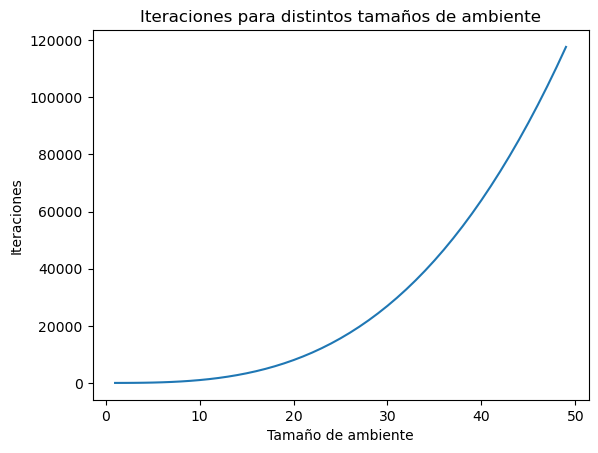

In [13]:
import matplotlib.pyplot as plt


env_sizes = range(1, 50)  # Explore some size range  
counts = []
value_functions = []

for size in env_sizes:
    env = GridworldEnv(shape=[size, size])
    policy, v, count = value_iteration(env)
    counts.append(count)
    value_functions.append(v)

    
print("Algunas funciones de valor:")
print(f"Ambiente 5x5: {value_functions[5]}")
print(f"Ambiente 10x10: {value_functions[10]}")
print(f"Ambiente 17x17: {value_functions[17]}")
print(f"Ambiente 25x25: {value_functions[25]}")

print(np.reshape(np.argmax(policy, axis=1), env.shape))

plt.plot(env_sizes, counts)
plt.xlabel("Tamaño de ambiente")
plt.ylabel("Iteraciones")
plt.title("Iteraciones para distintos tamaños de ambiente")
plt.show()

# Como resetear un estado

In [27]:
def resettostate(env,ns):
    env.reset()
    env.state = env.unwrapped.state = env.s = ns

In [33]:
env = GridworldEnv()
ns = 1 
resettostate(env,ns)
#env.state(DOWN)

# Graphviz

Generar dibujo de grafos (generado con ChatGPT)

In [34]:
#!pip install graphviz

In [50]:
grid = GridworldEnv([2,2])
grid.transition_probabilities

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 1, -1.0, False)],
  2: [(1.0, 3, -1.0, True)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 3, -1.0, True)],
  2: [(1.0, 2, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 3: {0: [(1.0, 3, 0.0, True)],
  1: [(1.0, 3, 0.0, True)],
  2: [(1.0, 3, 0.0, True)],
  3: [(1.0, 3, 0.0, True)]}}

In [51]:
# GRAPH VISUALIZATION
COLORS = ['blue', 'red', 'green', 'black']
ACTIONNAME = ['UP','RIGHT', 'DOWN', 'LEFT']
NUMBER_STATES = len(grid.transition_probabilities.keys())
NUMBER_ACTIONS = 4

In [52]:
import graphviz

def genGraf(t):
    # Create Diagraph object
    dot = graphviz.Digraph(comment='Magic World')
    # Add nodes
    for node in range(NUMBER_STATES):
        if node == NUMBER_STATES - 1 or node == 0:
            dot.attr('node', shape='doublecircle')
        else: 
            dot.attr('node', shape='circle')
        dot.node('S'+str(node), 'State ' + str(node))
    ## Add edges
    for s in range(NUMBER_STATES):
        for a in range(NUMBER_ACTIONS):
            for prob, nextstate,reward,done in t[s][a]:
                if prob != 0 and not(s == NUMBER_STATES -1 or s == 0):
                    dot.edge('S'+str(s), 'S'+str(nextstate),color= COLORS[a], label=ACTIONNAME[a]+', '+str(prob)+', '+str(reward))
    return dot

## Gridworld 2 x 2

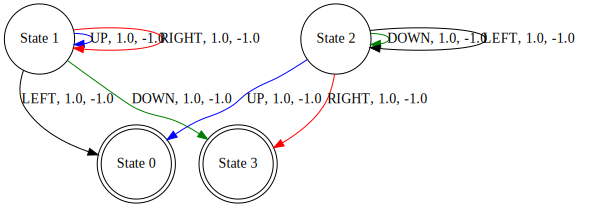

In [59]:
dim = 2
grid = GridworldEnv([dim,dim])
grid.transition_probabilities
NUMBER_STATES = len(grid.transition_probabilities.keys())

genGraf(grid.transition_probabilities)

## Gridworld 5 x 5

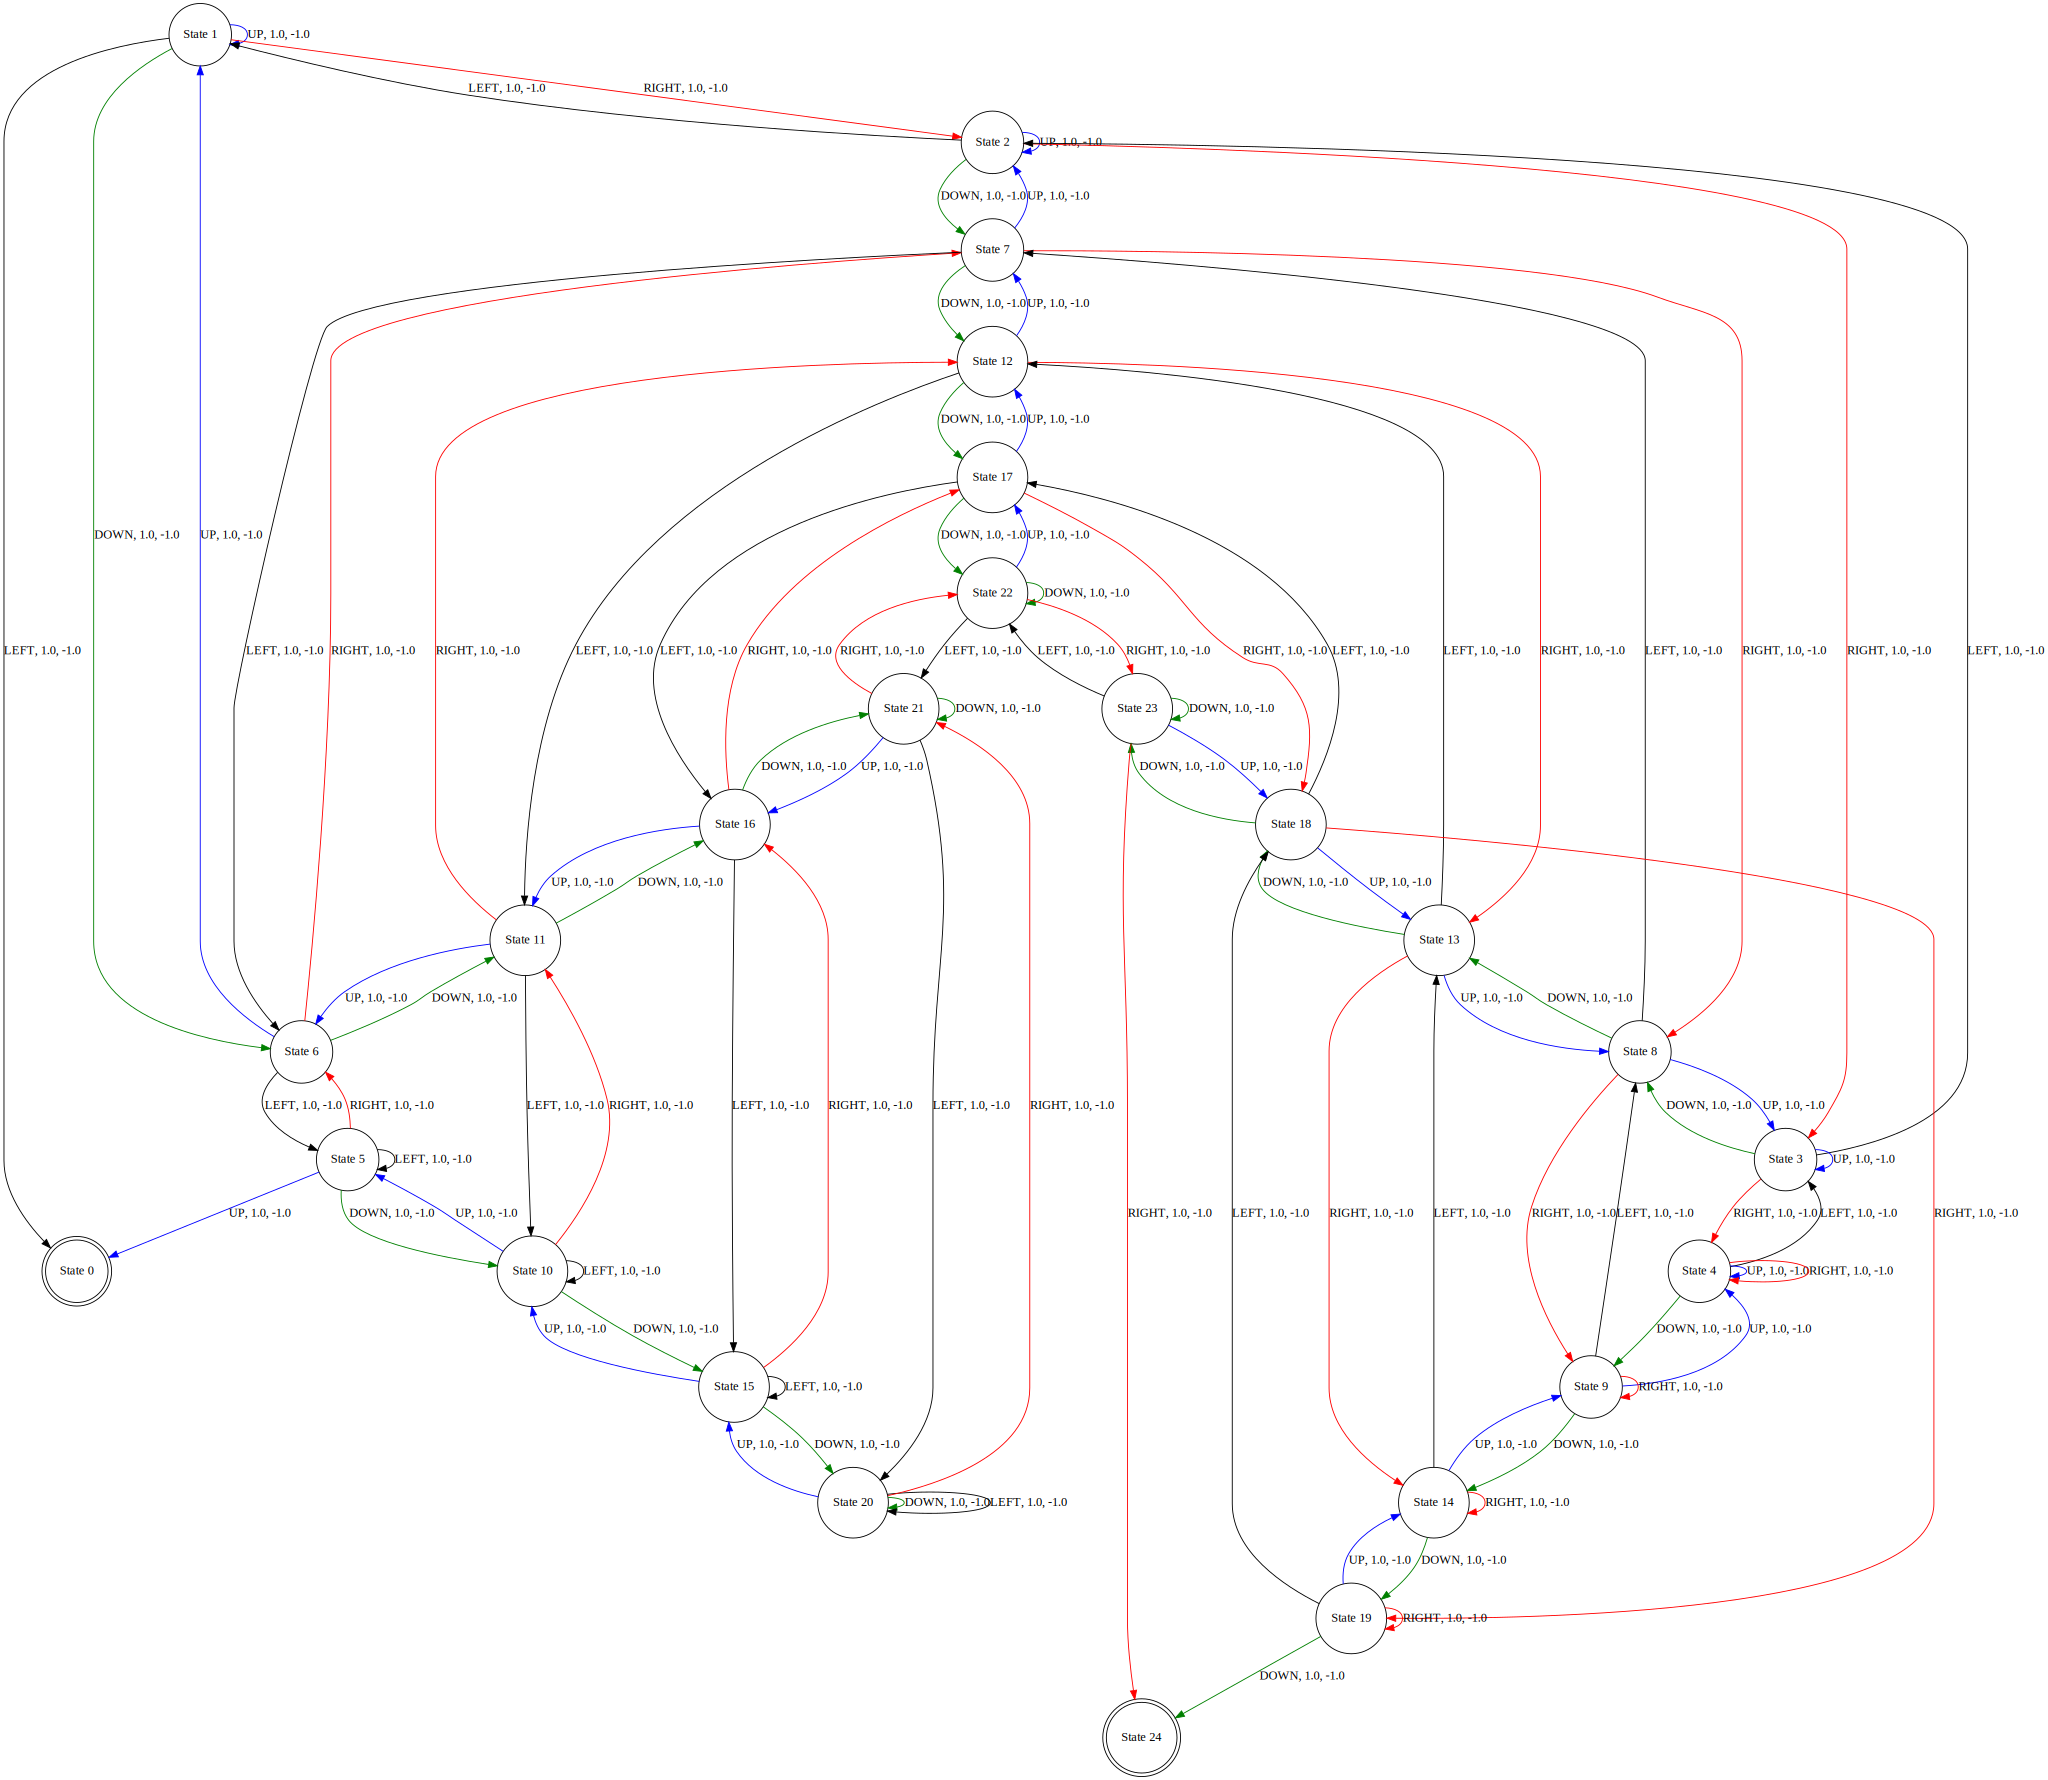

In [60]:
dim = 5
grid = GridworldEnv([dim,dim])
grid.transition_probabilities
NUMBER_STATES = len(grid.transition_probabilities.keys())

genGraf(grid.transition_probabilities)